In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../lib")
import seaborn as sns
import matplotlib.pyplot as plt
from utils import iterate_over
from utils import load_config_and_check
from inspector import Inspector
from tqdm import tqdm
import sqlite3 as sl
import os

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
# GOAL: experiment with various generation algortihms in QASM language.
# some examples are: 
# - use new gates
# - create particular sequences (present in the optimization routines)
# - use gates with very small or very big floating numbers
# - in circuit measurment (not only at the end)
# - simmetric circuit with compute and uncompute
# - completely deterministic circuit
# - multiple registers (classical and quantum)

In [4]:
QASM_PATH = "stub_files/easy_example.qasm"
QASM_CONTENT = open(QASM_PATH, 'r').read()
print(QASM_CONTENT)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
creg c[4];
h q[0];
cx q[0], q[1];
ry(1.11) q[2];
rz(2.22) q[2];
cx q[2], q[3];
h q[3];
h q[1];
barrier q;
measure q -> c;


## Test Existing Generator

In [5]:
from generation_strategy import WeightedRandomCircuitGenerator

In [7]:
gate_set ={
    "cx": 3,
    "rx": 1,
    "ry": 1,
    "rz": 1,
    "p": 1,
}

In [22]:
generator = WeightedRandomCircuitGenerator(
    out_folder="stub_files", benchmark_name="5_gates_generator")
qasm_content, metadata = generator.generate(
    n_qubits=5, n_ops_range=(10, 20), gate_set=gate_set, random_seed=42, 
    circuit_id="5_gates", in_memory=True)

--------------------------------------------------------------------------------
Creating circuit: 5_gates


In [23]:
print(qasm_content)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[5];
cx q[4], q[2];
ry(0.9801424781769557) q[0];
cx q[4], q[2];
ry(6.094123332392967) q[0];
rz(1.1424399624340646) q[1];
cx q[1], q[3];
rx(3.844385118274953) q[1];
cx q[1], q[2];
rx(1.2545873742863833) q[3];
rx(0.29185655071471744) q[2];
ry(0.4087312132537349) q[0];
U(0,5.0793103400482895,0) q[4];
cx q[0], q[3];
rx(3.1112882860657196) q[0];
cx q[4], q[1];
ry(3.267683749398383) q[1];
rx(6.092079887237463) q[0];
rz(5.622366060669442) q[4];
ry(0.55601478868818) q[4];
cx q[0], q[2];
barrier q;
measure q -> c;



## New Gates

In [ ]:
# GOAL: experiment with various generation algortihms in QASM language.
# some examples are: 
# - use new gates (X, Y, Z, id, )

In [53]:
from tket_interface import convert_and_execute_qiskit_and_cirq_via_tket

In [25]:
from generation_strategy import GenerationStrategy

In [123]:
import math
import random


OMNI_GATES = [
    #{"name": "cxx", "n_params": 0, "n_bits": 3},
    
    {"name": "cx", "n_params": 0, "n_bits": 2},
    #{"name": "cy", "n_params": 0, "n_bits": 2},
    #{"name": "cz", "n_params": 0, "n_bits": 2},
    #{"name": "ch", "n_params": 0, "n_bits": 2},
    {"name": "swap", "n_params": 0, "n_bits": 2},
    #{"name": "rxx", "n_params": 1, "n_bits": 2},
    #{"name": "ryy", "n_params": 1, "n_bits": 2},
    
    {"name": "id", "n_params": 0, "n_bits": 1},
    #{"name": "u0", "n_params": 1, "n_bits": 1},
    {"name": "u1", "n_params": 1, "n_bits": 1},
    {"name": "u2", "n_params": 2, "n_bits": 1},
    {"name": "u3", "n_params": 3, "n_bits": 1},
    
    {"name": "x", "n_params": 0, "n_bits": 1},
    {"name": "y", "n_params": 0, "n_bits": 1},
    {"name": "z", "n_params": 0, "n_bits": 1},
    {"name": "h", "n_params": 0, "n_bits": 1},
    {"name": "s", "n_params": 0, "n_bits": 1},
    #{"name": "sdg", "n_params": 0, "n_bits": 1},
    {"name": "t", "n_params": 0, "n_bits": 1},
    #{"name": "tdg", "n_params": 0, "n_bits": 1},
    
    #{"name": "p", "n_params": 1, "n_bits": 1},
    {"name": "rx", "n_params": 1, "n_bits": 1},
    {"name": "ry", "n_params": 1, "n_bits": 1},
    {"name": "rz", "n_params": 1, "n_bits": 1},
]


class OmniGateCircuitGenerator(GenerationStrategy):
    
    def _generate_n_params(self, n_params: int):
        numeric_prams = np.random.uniform(
            low=0, high=2 * math.pi, size=n_params)
        str_params = [str(e) for e in numeric_prams]
        return "(" + ",".join(str_params) + ")"
    
    def _generate_n_qubits(self, n_qubits: int, total_qubits: int):
        numeric_qubits = np.random.choice(np.arange(total_qubits), n_qubits, replace=False)
        str_qubits = [f"q[{e}]" for e in numeric_qubits]
        return ", ".join(str_qubits)

    def _random_concatenation(self, n_qubits: int, n_ops: int):
        """Random strategy: select a gate according to its weight."""
        circuit_qasm = 'OPENQASM 2.0;\ninclude "qelib1.inc";\n'
        
        np.random.seed(self.random_seed)
        
        qubits = range(n_qubits)
        circuit_qasm += f"qreg q[{n_qubits}];\n"
        circuit_qasm += f"creg c[{n_qubits}];\n"
        
        for i_op in range(n_ops):
            op = np.random.choice(self.gate_set, 1)[0]
            print(op)
            i_instr = f'{op["name"]}'
            if op["n_params"] > 0:
                i_instr += f'{self._generate_n_params(n_params=op["n_params"])}'
            i_instr += f' {self._generate_n_qubits(n_qubits=op["n_bits"], total_qubits=n_qubits)}'
            i_instr += ';\n'
            
            circuit_qasm += i_instr
            
        # circuit_qasm += f"barrier q;\n"
        # Measure
        circuit_qasm += f"measure q -> c;\n"
        return circuit_qasm

    def _generate_single_program(self, circuit_id: str):
        """Generate a single QASM program."""
        print("-" * 80)
        print(f"Creating circuit: {circuit_id}")

        random.seed(self.random_seed)
        n_ops = random.randint(self.min_n_ops, self.max_n_ops)

        # generate a random circuit
        random_circuit_qasm_str = self._random_concatenation(
            n_qubits=self.n_qubits,
            n_ops=n_ops)

        metadata_dict = {
            "n_qubits": self.n_qubits,
            "n_ops": n_ops,
            "gate_set": self.gate_set,
            "strategy_program_generation": self.__class__.__name__
        }

        return random_circuit_qasm_str, metadata_dict

In [124]:
generator = OmniGateCircuitGenerator(
    out_folder="stub_files", benchmark_name="omni_gates_generator")
qasm_content, metadata = generator.generate(
    n_qubits=5, n_ops_range=(10, 20), gate_set=OMNI_GATES, random_seed=42, 
    circuit_id="omni_gates", in_memory=False)

--------------------------------------------------------------------------------
Creating circuit: omni_gates
{'name': 'x', 'n_params': 0, 'n_bits': 1}
{'name': 'y', 'n_params': 0, 'n_bits': 1}
{'name': 'id', 'n_params': 0, 'n_bits': 1}
{'name': 'y', 'n_params': 0, 'n_bits': 1}
{'name': 'y', 'n_params': 0, 'n_bits': 1}
{'name': 't', 'n_params': 0, 'n_bits': 1}
{'name': 'rx', 'n_params': 1, 'n_bits': 1}
{'name': 'h', 'n_params': 0, 'n_bits': 1}
{'name': 'ry', 'n_params': 1, 'n_bits': 1}
{'name': 'z', 'n_params': 0, 'n_bits': 1}
{'name': 'u2', 'n_params': 2, 'n_bits': 1}
{'name': 'h', 'n_params': 0, 'n_bits': 1}
{'name': 'u1', 'n_params': 1, 'n_bits': 1}
{'name': 'rz', 'n_params': 1, 'n_bits': 1}
{'name': 'u1', 'n_params': 1, 'n_bits': 1}
{'name': 'rz', 'n_params': 1, 'n_bits': 1}
{'name': 'u1', 'n_params': 1, 'n_bits': 1}
{'name': 'u2', 'n_params': 2, 'n_bits': 1}
{'name': 't', 'n_params': 0, 'n_bits': 1}
{'name': 'rx', 'n_params': 1, 'n_bits': 1}


In [125]:
print(qasm_content)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[5];
x q[1];
y q[3];
id q[3];
y q[4];
y q[0];
t q[3];
rx(2.713990594641554) q[1];
h q[0];
ry(4.933406064175189) q[0];
z q[1];
u2(2.8305702808704267,0.08334620905998126) q[4];
h q[2];
u1(1.5144076667907493) q[4];
rz(1.0892822437043135) q[4];
u1(1.9585384533701249) q[2];
rz(5.292231320196365) q[0];
u1(3.756716362028796) q[4];
u2(2.442131435811337,1.7049362495591496) q[2];
t q[1];
rx(5.040352282937607) q[1];
measure q -> c;



In [100]:
res = convert_and_execute_qiskit_and_cirq_via_tket(
    qasm_path="stub_files/omni_gates.qasm", shots=8192
)
res.keys()

dict_keys(['qiskit', 'cirq', 'profile_output', 'profile_function_calls', 'profile_n_function_calls', 'profile_time'])

In [102]:
from detectors import KS_Detector
detector = KS_Detector()

In [104]:
stat, pval = detector.check(res['qiskit'], res['cirq'])
stat, pval 

(0.5206298828125, 0.0)

In [108]:
from inspector import convert_dict_to_df
from inspector import Inspector

In [117]:
sherlock = Inspector(folder_executions="stub_files/")
sherlock.df_melted = convert_dict_to_df(
    res_a=res["cirq"],res_b=res["qiskit"], 
    platform_a='cirq', platform_b='qiskit'
)

```qasm
OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[5];
x q[1];
y q[3];
id q[3];
y q[4];
y q[0];
t q[3];
rx(2.713990594641554) q[1];
h q[0];
ry(4.933406064175189) q[0];
z q[1];
u2(2.8305702808704267,0.08334620905998126) q[4];
h q[2];
u1(1.5144076667907493) q[4];
rz(1.0892822437043135) q[4];
u1(1.9585384533701249) q[2];
rz(5.292231320196365) q[0];
u1(3.756716362028796) q[4];
u2(2.442131435811337,1.7049362495591496) q[2];
t q[1];
rx(5.040352282937607) q[1];
barrier q;
measure q -> c;
```

n_qubits: 5
n_shots: 8192.0
Uniform threshold: 256.0


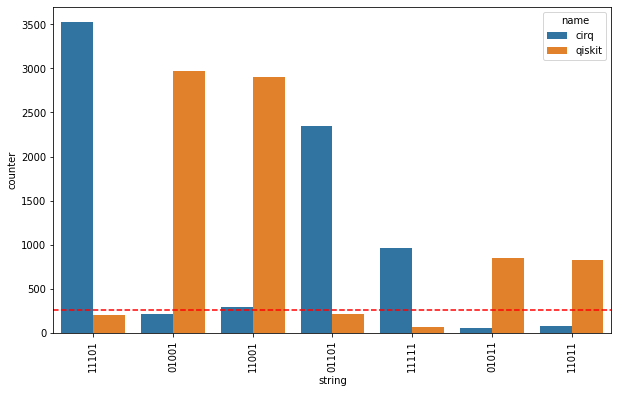

In [118]:
sherlock.plot_histogram_together()

### Execution in Qiskit Native

In [113]:
import qiskit
from qiskit import QuantumCircuit
from qiskit import Aer, transpile


In [153]:
qc = QuantumCircuit.from_qasm_file("stub_files/omni_gates.qasm")
# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
#qc = transpile(qc, simulator)
print(qc.draw(fold=-1))
# Run and get counts
result = simulator.run(qc, shots=8192).result()
counts_qiskit = result.get_counts(qc)

     ┌───┐         ┌───┐             ┌────────────┐   ┌────────────┐                               ┌─┐      
q_0: ┤ Y ├─────────┤ H ├─────────────┤ Ry(4.9334) ├───┤ Rz(5.2922) ├───────────────────────────────┤M├──────
     ├───┤     ┌───┴───┴───┐         └───┬───┬────┘   └───┬───┬────┘┌────────────┐                 └╥┘┌─┐   
q_1: ┤ X ├─────┤ Rx(2.714) ├─────────────┤ Z ├────────────┤ T ├─────┤ Rx(5.0404) ├──────────────────╫─┤M├───
     ├───┤     ├───────────┴┐    ┌───────┴───┴───────┐    └───┘     └────┬─┬─────┘                  ║ └╥┘   
q_2: ┤ H ├─────┤ U1(1.9585) ├────┤ U2(2.4421,1.7049) ├───────────────────┤M├────────────────────────╫──╫────
     ├───┤     └───┬───┬────┘    └───────┬───┬───────┘                   └╥┘      ┌─┐               ║  ║    
q_3: ┤ Y ├─────────┤ I ├─────────────────┤ T ├────────────────────────────╫───────┤M├───────────────╫──╫────
     ├───┤┌────────┴───┴────────┐    ┌───┴───┴────┐   ┌────────────┐      ║       └╥┘┌────────────┐ ║  ║ ┌─┐
q_4: ┤ Y ├┤ U2(2.83

In [148]:
counts_qiskit = dict(sorted(counts_qiskit.items(), key=lambda item: item[1], reverse=True))

counts_qiskit

{'11001': 2977,
 '01001': 2968,
 '11011': 822,
 '01011': 785,
 '11101': 222,
 '01101': 196,
 '01111': 64,
 '11111': 52,
 '11000': 41,
 '01000': 39,
 '11010': 13,
 '01010': 7,
 '11100': 4,
 '01100': 1,
 '11110': 1}

### Native Cirq execution

In [150]:
import cirq
from cirq.contrib.qasm_import import circuit_from_qasm
import re

from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

qc_cirq = circuit_from_qasm(qasm_content)
print(qc_cirq)

simulator = cirq.Simulator()
result = simulator.run(qc_cirq, repetitions=8192)

q_0: ───Y───H─────────────────────────────────────────────────────────────────────────────────────────────────Ry(1.57π)────────────────────────────────────────────────────────────────────────────────────────Rz(1.69π)────M('c_0')──────────────────────────────────────────────────────────────────────────────────

q_1: ───X───Rx(0.864π)────────────────────────────────────────────────────────────────────────────────────────Z────────────────────────────────────────────────────────────────────────────────────────────────T────────────Rx(1.6π)───────────────────────────────────────────────────────────────────────M('c_1')───

q_2: ───H───cirq.circuits.qasm_output.QasmUGate(theta=0, phi=0, lmda=0.6234221521788219)──────────────────────cirq.circuits.qasm_output.QasmUGate(theta=0.5, phi=0.777354579378964, lmda=0.5426980635477918)───M('c_2')───────────────────────────────────────────────────────────────────────────────────────────────

q_3: ───Y───I───────────────────────────────────────────────────

In [141]:
from functools import reduce

measurement_keys = list(qc_cirq.all_measurement_key_names())
print(measurement_keys)
result_dict = dict(result.multi_measurement_histogram(keys=measurement_keys))
keys = list(map(lambda arr: reduce(lambda x, y: str(x) + str(y), arr[::-1]), result_dict.keys()))
counts_cirq = dict(zip(keys,[value for value in result_dict.values()]))
counts_cirq

['c_2', 'c_4', 'c_3', 'c_1', 'c_0']


{'10110': 2944,
 '10100': 3010,
 '11110': 788,
 '11100': 833,
 '10101': 207,
 '10111': 209,
 '00100': 43,
 '01110': 11,
 '00110': 34,
 '11111': 55,
 '11101': 47,
 '01100': 5,
 '00111': 2,
 '00101': 2,
 '01111': 1,
 '01101': 1}

In [ ]:
# - create particular sequences (present in the optimization routines)
# - use gates with very small or very big floating numbers
# - in circuit measurment (not only at the end)
# - simmetric circuit with compute and uncompute
# - completely deterministic circuit